In [28]:
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob

In [29]:
K = np.loadtxt('K.txt')
K

array([[3.1174740e+03, 0.0000000e+00, 1.5019408e+03],
       [0.0000000e+00, 3.1174740e+03, 9.8476840e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

In [30]:
image_folder_path = "sequence/*"
images = []
# Remember to sort, or else glob doesnt return it in sequence
for name in sorted(glob.glob(image_folder_path)):
    print(name)
    image = cv2.imread(name)
    images.append(image)
len(images)

sequence/000001.png
sequence/000002.png
sequence/000003.png
sequence/000004.png
sequence/000005.png
sequence/000006.png
sequence/000007.png
sequence/000008.png
sequence/000009.png
sequence/000010.png
sequence/000011.png
sequence/000012.png
sequence/000013.png
sequence/000014.png
sequence/000015.png
sequence/000016.png
sequence/000017.png
sequence/000018.png
sequence/000019.png
sequence/000020.png


20

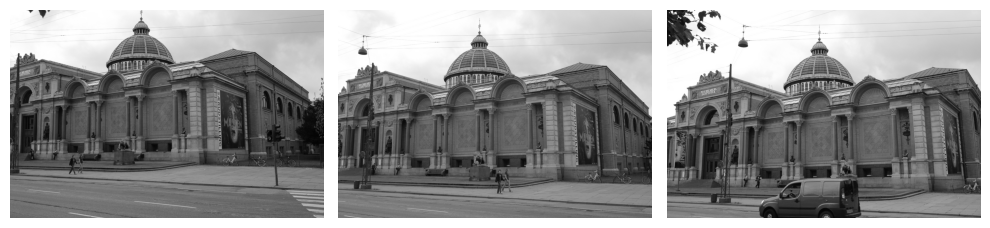

In [31]:
# Plot the first 3 images
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i in range(3):
    axes[i].imshow(images[i])
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## Ex 11.1

In [32]:
def find_features(im1, im2, plot=False):
    """
    Find matching features between two images.

    Args:
        im1 (np.ndarray): The first image.
        im2 (np.ndarray): The second image.

    Returns:
        matches (list): Matching features (cv2.DMatch objects).
        kp1 (list): Keypoints in the first image.
        kp2 (list): Keypoints in the second image.
    """
    # Limit features to reduce computation and also prevent out of bound issues when matching
    n_features = 2000
    # Initiate SIFT detector
    sift = cv2.SIFT_create(nfeatures=n_features)

    # Find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(im1, None)
    kp2, des2 = sift.detectAndCompute(im2, None)

    # Create BFMatcher object
    bf = cv2.BFMatcher(crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)  # ascending

    # Draw first 10 matches.
    if plot:
        img3 = cv2.drawMatches(
            im1,
            kp1,
            im2,
            kp2,
            matches[:30],
            None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        )
        mpl.rcParams["figure.figsize"] = [15, 10]
        plt.imshow(img3)
        plt.axis("off")
        plt.title("Closest 30 matches")
        plt.show()
        mpl.rcParams["figure.figsize"] = [8, 6]

    return matches, kp1, kp2

In [33]:
# Feature matching is correct when the connecting lines are mostly parallel.
im0 = images[0]
im1 = images[1]
im2 = images[2]

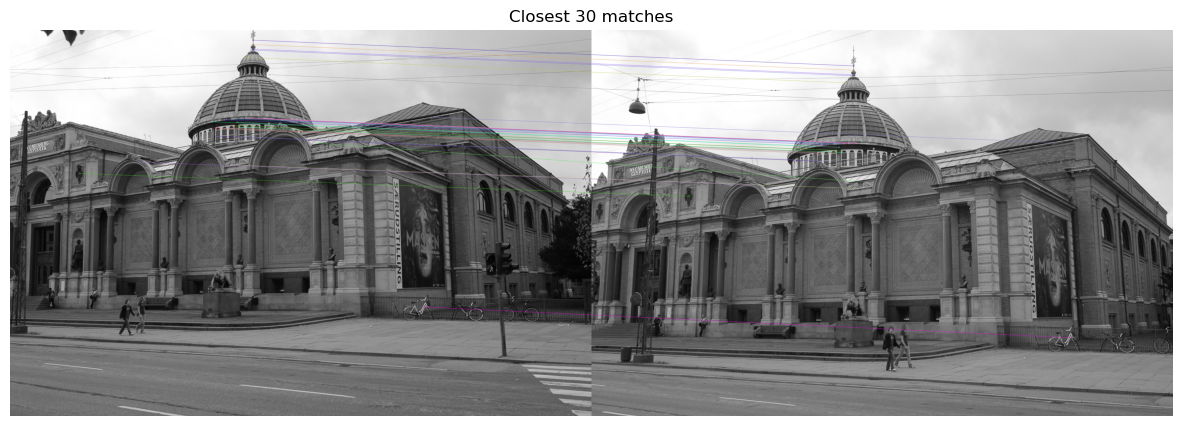

In [34]:
matches01, kp0, kp1 = find_features(im0, im1, plot=True)

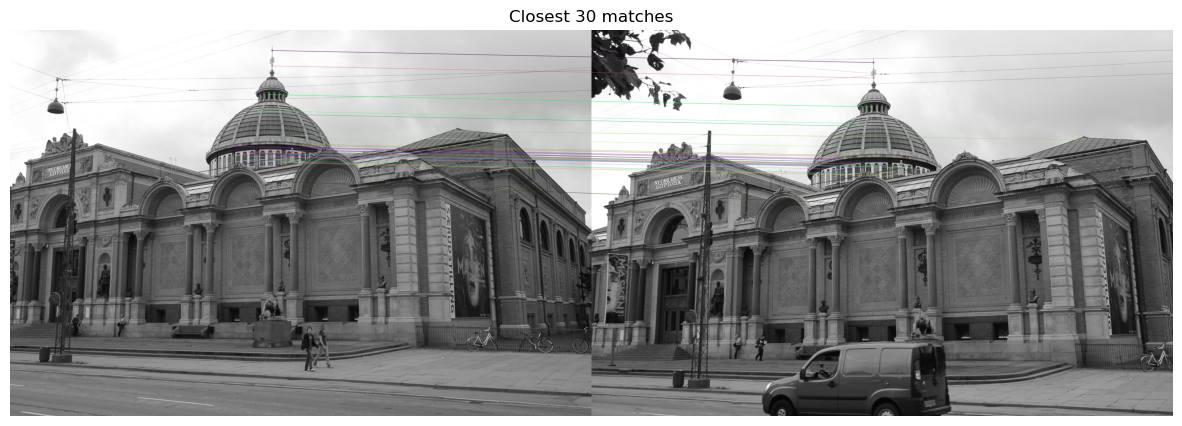

In [35]:
matches12, kp1, kp2 = find_features(im1, im2, plot=True)

In [36]:
matches01 = np.array([(m.queryIdx, m.trainIdx) for m in matches01])
matches12 = np.array([(m.queryIdx, m.trainIdx) for m in matches12])
matches01.shape, matches12.shape

((958, 2), (860, 2))

In [37]:
kp0 = np.array([k.pt for k in kp0])
kp1 = np.array([k.pt for k in kp1])
kp2 = np.array([k.pt for k in kp2])
kp0.shape, kp1.shape, kp2.shape

((2000, 2), (2003, 2), (2000, 2))

## Ex 11.2

In [38]:
points0 = kp0[matches01[:, 0]]
points1 = kp1[matches01[:, 1]]
E, mask = cv2.findEssentialMat(
    points1=points0,
    points2=points1,
    cameraMatrix=K,
)
points, R_est, t_est, mask_pose = cv2.recoverPose(E, points0, points1, K)
mask_pose = (mask_pose / 255).astype(int)
mask.shape, mask_pose.shape, R_est, t_est 

((958, 1),
 (958, 1),
 array([[ 0.99988302, -0.00911817, -0.01228027],
        [ 0.00969074,  0.99882889,  0.04740179],
        [ 0.01183367, -0.04751525,  0.99880041]]),
 array([[ 0.9245921 ],
        [-0.06757135],
        [-0.37491808]]))

The mask returned by cv2.recoverPose indicates which matches, that lie in front of both cameras.
Combine this mask with the mask from cv2.findEssentialMat, to get the matches that are both
1
inliers and lie in front of both cameras. Remove the matches that are not inliers from matches01,
so that only contains the inliers.

In [39]:
combined_mask = np.logical_and(mask, mask_pose)
print(combined_mask.sum())
inlier_matches = matches01[combined_mask.ravel()]
inlier_matches.shape

687


(687, 2)

## Ex 11.3

In [40]:
# Already filtered in the first step for 01, this is an overlap, so the filter is alr applied
_, idx01, idx12 = np.intersect1d(
    inlier_matches[:, 1], matches12[:, 0], return_indices=True
)
idx01.shape, idx12.shape

((362,), (362,))

In other words, create three lists such that points0[i],
points1[i], and points2[i] are the 2D locations of the same point in the corresponding images.

![WHAT](images/WHAT.png)
![help](images/indexing.png)

In [41]:
common_point0 = kp0[inlier_matches[idx01, 0]]
common_point1 = kp1[inlier_matches[idx01, 1]]
common_point2 = kp2[matches12[idx12, 1]]
# Alternative
# common_point0 = kp0[inlier_matches[idx01][:, 0]]
# common_point1 = kp1[inlier_matches[idx01][:, 1]]
# common_point2 = kp2[matches12[idx12][:, 1]]#, AHHHHH WTF 
common_point0.shape, common_point1.shape, common_point2.shape

((362, 2), (362, 2), (362, 2))

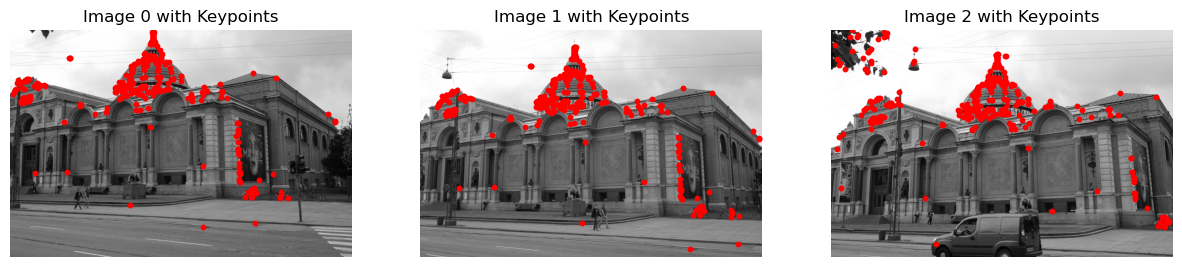

In [42]:
# Plot the matches

# Plot the keypoints on images 0, 1, and 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot image 0 with keypoints
axes[0].imshow(cv2.cvtColor(im0, cv2.COLOR_BGR2RGB))
axes[0].scatter(common_point0[:, 0], common_point0[:, 1], c="r", s=10)
axes[0].set_title("Image 0 with Keypoints")
axes[0].axis("off")

# Plot image 1 with keypoints
axes[1].imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
axes[1].scatter(common_point1[:, 0], common_point1[:, 1], c="r", s=10)
axes[1].set_title("Image 1 with Keypoints")
axes[1].axis("off")

# Plot image 2 with keypoints
axes[2].imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
axes[2].scatter(common_point2[:, 0], common_point2[:, 1], c="r", s=10)
axes[2].set_title("Image 2 with Keypoints")
axes[2].axis("off")

plt.show()

## Ex 11.4
For the points that have been tracked through all three images, use the 2D positions in image 0
and 1 to triangulate the points in 3D (Q). Using the 2D positions in image 2, estimate the pose
of image 2 with RANSAC. Use cv2.solvePnPRansac to do this. As the lens distortion is already
corrected, you can set distCoeffs = np.zeros(5).

In [43]:
import sys
import os

# Get the absolute path to the parent directory containing "02504 Computer Vision"
parent_dir = os.path.abspath(os.path.join("../..", "02504-Computer-Vision"))

# Add it to sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utility import Pi, Piinv

In [44]:
def triangulate(pixel_coords: np.array, proj_matrices: np.array):
    """
    Given a list of pixel coordinates and projection matrices, triangulate to a common 3D point
    Args:
        pixel_coords (np.array): list of pixel coordinates
        proj_matrices (np.array): list of projection matrices

    Return:
        triangle (np.array): triangulated 3D point
    """
    n = pixel_coords.shape[0]
    # B_stack = []
    B_stack = np.zeros((n * 2, 4))
    for i in range(n):
        x, y = pixel_coords[i]
        proj_matrix = proj_matrices[i]
        B = np.asarray(
            [
                proj_matrix[2, :] * x - proj_matrix[0, :],
                proj_matrix[2, :] * y - proj_matrix[1, :],
            ]
        )
        B_stack = np.vstack((B_stack, B))
    U, S, Vt = np.linalg.svd(B_stack)
    # Get the smallest vector
    print(f"Vt is {Vt}")
    triangle = Vt[-1, :]
    triangle /= triangle[-1]
    return triangle

Run triangulate for all matches, get a list of 3D points

In [45]:
Q_ests = []
num_points = common_point0.shape[0]
for i in range(num_points):
    point0 = common_point0.T[:, i] # 2 x 1 shape
    point1 = common_point1.T[:, i] # 2 x 1 shape
    pixel_coords = np.array([point0, point1])
    # Note has to be shape (3,1), (3,) would run into errors as its missing a dim
    P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = K @ np.concatenate((R_est, t_est), axis=1)
    proj_matrices = np.array([P1, P2])
    # InHomogenenous coordinates
    Q_est = Pi(triangulate(pixel_coords, proj_matrices).reshape(4, 1))
    Q_ests.append(Q_est)

Q_ests = np.array(Q_ests)
Q_ests.shape

Vt is [[-0.86236941  0.14555511 -0.00256474 -0.48489807]
 [ 0.16421068  0.94572702  0.28025409 -0.00963839]
 [ 0.47335555 -0.10455005  0.04541225 -0.87346525]
 [ 0.07272126  0.27107821 -0.95884764 -0.04288855]]
Vt is [[-0.85830178  0.16434618  0.00771756 -0.48605435]
 [ 0.18377447  0.93492298  0.30353443 -0.00358064]
 [ 0.47367091 -0.10971993  0.04087041 -0.87288431]
 [ 0.07197829  0.29473869 -0.95191223 -0.04255975]]
Vt is [[-0.87621047  0.07438881 -0.0665472  -0.47147957]
 [ 0.08606949  0.98264662  0.16194554 -0.02777235]
 [ 0.46037095 -0.07922383  0.08511065 -0.88007861]
 [ 0.11360391  0.15031802 -0.98086762 -0.0489628 ]]
Vt is [[-0.83740414  0.13176599  0.12645661 -0.51517061]
 [ 0.157306    0.97923915  0.12527793  0.02551375]
 [ 0.51834745 -0.06461863  0.02779886 -0.85227201]
 [-0.07297292  0.1398315  -0.98363682 -0.08706731]]
Vt is [[-0.87217636  0.08722403 -0.03242097 -0.48025956]
 [ 0.10069058  0.98512838  0.13858808 -0.01329746]
 [ 0.47246382 -0.07020532  0.07176054 -0.8756138

(362, 3, 1)

Using the 2D positions in image 2, estimate the pose
of image 2 with RANSAC. Use cv2.solvePnPRansac to do this. As the lens distortion is already
corrected, you can set distCoeffs = np.zeros(5)

## Test with cv2 triangulate function

In [46]:
P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = K @ np.concatenate((R_est, t_est), axis=1)
# InHomogenenous coordinates
Q_cv2 = Pi(cv2.triangulatePoints(projMatr1=P1, projMatr2=P2, projPoints1=common_point0.T, projPoints2=common_point1.T))
Q_cv2.shape, Q_cv2.dtype


((3, 362), dtype('float64'))

In [47]:
Q_ests.shape, common_point2.shape

((362, 3, 1), (362, 2))

In [48]:
Q_cv2 = Q_cv2.T

In [49]:
print("Shape of objectPoints (Q_cv2):", Q_cv2.shape)
print("Shape of imagePoints (common_point2):", common_point2.shape)
assert (
    Q_cv2.shape[0] >= 4
), f"objectPoints has only {Q_cv2.shape[0]} points, need at least 4"
assert (
    common_point2.shape[0] >= 4
), f"imagePoints has only {common_point2.shape[0]} points, need at least 4"
assert (
    Q_cv2.shape[0] == common_point2.shape[0]
), f"Mismatch: objectPoints has {Q_cv2.shape[0]} points, imagePoints has {common_point2.shape[0]} points"

Shape of objectPoints (Q_cv2): (362, 3)
Shape of imagePoints (common_point2): (362, 2)


In [50]:
distCoeffs = np.zeros(5)
Q_ests = np.squeeze(Q_ests)
print(Q_ests.shape)
success, rvec, tvec, inliers = cv2.solvePnPRansac(objectPoints=Q_ests, imagePoints=common_point2, cameraMatrix=K, distCoeffs=distCoeffs)
assert success
rvec, tvec, inliers.shape

(362, 3)


(array([[-0.08006092],
        [-0.02319141],
        [ 0.00245579]]),
 array([[ 1.9726502 ],
        [-0.24902334],
        [-1.05750618]]),
 (275, 1))

In [51]:
distCoeffs = np.zeros(5)
common_point2 = common_point2.astype(np.float64)
print(common_point2.shape, common_point2.dtype)
success, rvec, tvec, inliers = cv2.solvePnPRansac(
    objectPoints=Q_cv2,
    imagePoints=common_point2,
    cameraMatrix=K,
    distCoeffs=distCoeffs,
)
assert success
rvec, tvec, inliers.shape

(362, 2) float64


(array([[-0.08006092],
        [-0.02319141],
        [ 0.00245579]]),
 array([[ 1.9726502 ],
        [-0.24902334],
        [-1.05750618]]),
 (275, 1))

(275, 3)


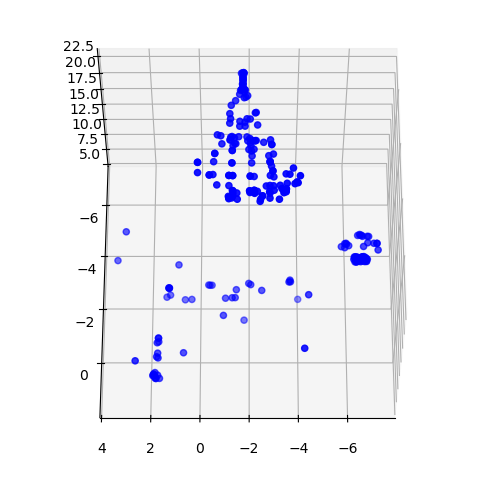

In [81]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
inlier_points = Q_ests[inliers.flatten()]
print(inlier_points.shape)
ax.scatter(inlier_points[:, 0], inlier_points[:, 1], inlier_points[:, 2], c='b', marker='o', label='Inlier Points')
ax.view_init(azim=90,elev=60)

for solve pnp, rvec and tvec is the tf from world to cam, do a projection from these inliers to the camera

In [95]:
rot_matrix = np.eye(3)
rot_matrix, _ =  cv2.Rodrigues(rvec)
# find tf from cam to world
R = rot_matrix.T 
t = -R @ tvec.reshape(3, 1)
camera_pose = R @ t
# R = rot_matrix
# t = -tvec.reshape(3, 1)
P3 = np.concatenate((R, t), axis=1)
P3 = np.vstack((P3, np.array([0, 0, 0, 1])))
P3.shape, P3, camera_pose.shape

((4, 4),
 array([[ 9.99728221e-01,  3.38077228e-03,  2.30662896e-02,
         -1.94687945e+00],
        [-1.52512251e-03,  9.96793967e-01, -7.99966280e-02,
          1.66636568e-01],
        [-2.32627887e-02,  7.99397077e-02,  9.96528216e-01,
          1.11963095e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 (3, 1))

(275, 3)


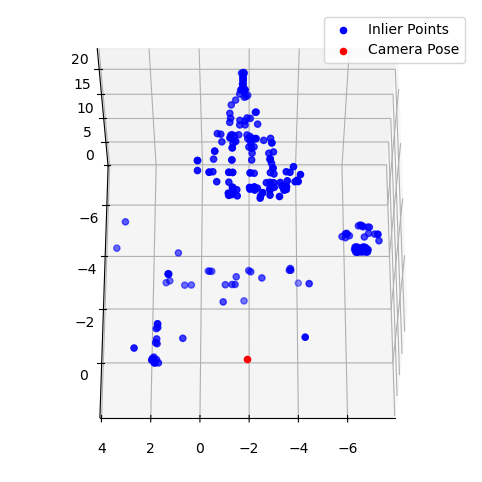

In [98]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")  # Using 111 for single subplot

# Plot inlier points
inlier_points = Q_ests[inliers.flatten()]
print(inlier_points.shape)
ax.scatter(
    inlier_points[:, 0],
    inlier_points[:, 1],
    inlier_points[:, 2],
    c="b",
    marker="o",
    label="Inlier Points",
)

# Plot camera points
ax.scatter(
    camera_pose.T[:, 0],
    camera_pose.T[:, 1],
    camera_pose.T[:, 2],
    c="r",
    marker="o",
    label="Camera Pose",
)

# Set view and legend
ax.view_init(azim=90, elev=60)
ax.legend()

plt.show()

You are at the origin of the camera, you need to  apply the tf cam -> world to get the camera position in world frame

## Alternative

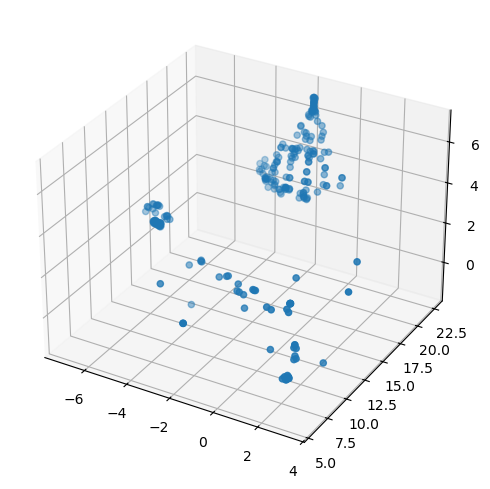

In [78]:
# Visualize 3D points
figure = plt.figure()
ax = figure.add_subplot(projection="3d")
points_show = (Q_ests[inliers.flatten()]).T
points_show[[1, 2], :] = points_show[[2, 1], :]
points_show[2, :] *= -1
ax.scatter(*(points_show))
plt.show()

https://github.com/polygon-software/python-visual-odometry/blob/master/Chapter%2010%20-%20RANSAC%20%26%20Bundle%20Adjustment.ipynb